1. Data Collection & HTML Parsing

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import csv

# Input and output file paths
input_file = "data.csv"        # your uploaded file containing URLs
output_file = "extracted_data.csv"

# Read URLs from CSV file (assume column name is 'url' or first column)
try:
    df = pd.read_csv(input_file)
    urls = df.iloc[:, 0].dropna().tolist()  # Take first column as URL list
except Exception as e:
    print(f"Error reading input file: {e}")
    urls = []

data = []

for url in urls:
    try:
        print(f"Processing: {url}")
        response = requests.get(url, timeout=10)
        response.raise_for_status()  # Raise error for bad responses

        # Parse HTML content
        soup = BeautifulSoup(response.text, "html.parser")

        # Extract page title
        title = soup.title.string.strip() if soup.title else "No Title"

        # Extract and clean main body text
        for script in soup(["script", "style"]):
            script.decompose()
        text = soup.get_text(separator=' ', strip=True)
        word_count = len(text.split())

        data.append({
            "URL": url,
            "Title": title,
            "WordCount": word_count,
            "Text": text
        })

    except Exception as e:
        print(f"Error processing {url}: {e}")
        data.append({
            "URL": url,
            "Title": "Error",
            "WordCount": 0,
            "Text": ""
        })

# Save results to CSV
try:
    pd.DataFrame(data).to_csv(output_file, index=False, quoting=csv.QUOTE_ALL)
    print(f"Extraction complete! Saved to {output_file}")
except Exception as e:
    print(f"Error saving file: {e}")


Processing: https://www.cm-alliance.com/cybersecurity-blog
Processing: https://www.varonis.com/blog/cybersecurity-tips
Processing: https://www.cisecurity.org/insights/blog/11-cyber-defense-tips-to-stay-secure-at-work-and-home
Processing: https://www.cisa.gov/topics/cybersecurity-best-practices
Processing: https://www.qnbtrust.bank/Resources/Learning-Center/Blog/7-cyber-security-tips
Processing: https://nordlayer.com/learn/network-security/basics/
Processing: https://www.fortinet.com/resources/cyberglossary/what-is-network-security
Processing: https://www.cisco.com/site/us/en/learn/topics/security/what-is-network-security.html
Processing: https://www.trendmicro.com/en_us/what-is/network-security/network-security-basics.html
Error processing https://www.trendmicro.com/en_us/what-is/network-security/network-security-basics.html: 429 Client Error: Too Many Requests for url: https://www.trendmicro.com/en_us/what-is/network-security/network-security-basics.html
Processing: https://digitdefen

In [3]:
clean_data=pd.read_csv("extracted_data.csv")
print(clean_data)

                                                  URL  \
0      https://www.cm-alliance.com/cybersecurity-blog   
1     https://www.varonis.com/blog/cybersecurity-tips   
2   https://www.cisecurity.org/insights/blog/11-cy...   
3   https://www.cisa.gov/topics/cybersecurity-best...   
4   https://www.qnbtrust.bank/Resources/Learning-C...   
..                                                ...   
76      https://www.cnbc.com/artificial-intelligence/   
77       https://www.bbc.com/news/topics/c404v061z99t   
78  https://www.theguardian.com/technology/artific...   
79     https://apnews.com/hub/artificial-intelligence   
80           https://abcnews.go.com/alerts/technology   

                                                Title  WordCount  \
0                                 Cyber Security Blog       2604   
1   Top 10 Cybersecurity Awareness Tips: How to St...       2509   
2   11 Cyber Defense Tips to Stay Secure at Work a...       1513   
3   Cybersecurity Best Practices | Cybersec

2. Text Preprocessing & Feature Engineering

In [4]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
import numpy as np
import csv

# Download NLTK data (run once)
nltk.download('punkt')
nltk.download('punkt_tab')

# Input/Output
input_file = "data.csv"
output_file = "extracted_features.csv"

# Load URLs
try:
    df = pd.read_csv(input_file)
    urls = df.iloc[:, 0].dropna().tolist()
except Exception as e:
    print(f"Error reading {input_file}: {e}")
    urls = []

# Load embedding model (you can change this to a smaller one if needed)
model = SentenceTransformer("all-MiniLM-L6-v2")

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def extract_text_from_url(url):
    try:
        r = requests.get(url, timeout=10)
        r.raise_for_status()
        soup = BeautifulSoup(r.text, "html.parser")
        for tag in soup(["script", "style", "noscript"]):
            tag.decompose()
        text = soup.get_text(separator=' ')
        return clean_text(text)
    except Exception as e:
        print(f"Error extracting from {url}: {e}")
        return ""

def get_top_keywords(text, top_n=5):
    try:
        vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
        tfidf_matrix = vectorizer.fit_transform([text])
        scores = tfidf_matrix.toarray()[0]
        words = vectorizer.get_feature_names_out()
        top_indices = scores.argsort()[-top_n:][::-1]
        top_words = [words[i] for i in top_indices]
        return "|".join(top_words)
    except:
        return ""

data = []

for url in urls:
    print(f"Processing: {url}")
    text = extract_text_from_url(url)
    if not text:
        data.append({
            "url": url,
            "word_count": 0,
            "sentence_count": 0,

            "top_keywords": "",
            "embedding": "[]"
        })
        continue

    # Basic metrics
    word_count = len(word_tokenize(text))
    sentence_count = len(sent_tokenize(text))


    # Top keywords
    top_keywords = get_top_keywords(text)

    # Embedding vector
    embedding = model.encode(text[:5000])  # limit length for safety
    embedding_str = "[" + ",".join([f"{x:.3f}" for x in embedding.tolist()]) + "]"

    data.append({
        "url": url,
        "word_count": word_count,
        "sentence_count": sentence_count,

        "top_keywords": top_keywords,
        "embedding": embedding_str
    })

# Save results
pd.DataFrame(data).to_csv(output_file, index=False, quoting=csv.QUOTE_ALL)
print(f"\n✅ Extraction complete! Saved to {output_file}")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Processing: https://www.cm-alliance.com/cybersecurity-blog
Processing: https://www.varonis.com/blog/cybersecurity-tips
Processing: https://www.cisecurity.org/insights/blog/11-cyber-defense-tips-to-stay-secure-at-work-and-home
Processing: https://www.cisa.gov/topics/cybersecurity-best-practices
Processing: https://www.qnbtrust.bank/Resources/Learning-Center/Blog/7-cyber-security-tips
Processing: https://nordlayer.com/learn/network-security/basics/
Processing: https://www.fortinet.com/resources/cyberglossary/what-is-network-security
Processing: https://www.cisco.com/site/us/en/learn/topics/security/what-is-network-security.html
Processing: https://www.trendmicro.com/en_us/what-is/network-security/network-security-basics.html
Error extracting from https://www.trendmicro.com/en_us/what-is/network-security/network-security-basics.html: 429 Client Error: Too Many Requests for url: https://www.trendmicro.com/en_us/what-is/network-security/network-security-basics.html
Processing: https://digit

In [5]:
data=pd.read_csv("extracted_features.csv")
print(data)

                                                  url  word_count  \
0      https://www.cm-alliance.com/cybersecurity-blog        2919   
1     https://www.varonis.com/blog/cybersecurity-tips        2853   
2   https://www.cisecurity.org/insights/blog/11-cy...        1707   
3   https://www.cisa.gov/topics/cybersecurity-best...        1321   
4   https://www.qnbtrust.bank/Resources/Learning-C...        1027   
..                                                ...         ...   
76      https://www.cnbc.com/artificial-intelligence/           0   
77       https://www.bbc.com/news/topics/c404v061z99t           0   
78  https://www.theguardian.com/technology/artific...         727   
79     https://apnews.com/hub/artificial-intelligence        6815   
80           https://abcnews.go.com/alerts/technology        2296   

    sentence_count                               top_keywords  \
0               67  2025|cyber|cybersecurity|security|october   
1              136         data|security|

3. Duplicate Detection

In [6]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import csv
import ast

# =========================================================
# CONFIGURATION
# =========================================================
input_file = "extracted_features.csv"
output_duplicates = "duplicate_pairs.csv"
output_summary = "content_summary.csv"

similarity_threshold = 0.80
thin_word_limit = 500
expected_dim = 384   # default for all-MiniLM-L6-v2 embeddings
# =========================================================

# ---------------------------------------------------------
# STEP 1: Load CSV
# ---------------------------------------------------------
try:
    df = pd.read_csv(input_file)
except Exception as e:
    raise RuntimeError(f"❌ Error reading {input_file}: {e}")

if "embedding" not in df.columns:
    raise ValueError("❌ 'embedding' column not found in input file!")

# ---------------------------------------------------------
# STEP 2: Parse and fix embeddings
# ---------------------------------------------------------
def parse_embedding_safe(emb_str):
    try:
        if isinstance(emb_str, str) and emb_str.strip() not in ["[]", "", "nan"]:
            emb = np.array(ast.literal_eval(emb_str), dtype=float)
            # Handle wrong dimension
            if emb.size == 0:
                return np.zeros(expected_dim)
            return emb
        else:
            return np.zeros(expected_dim)
    except:
        return np.zeros(expected_dim)

df["embedding"] = df["embedding"].apply(parse_embedding_safe)

# ---------------------------------------------------------
# STEP 3: Thin Content Flag
# ---------------------------------------------------------
df["is_thin"] = (df["word_count"] < thin_word_limit).astype(int)

# ---------------------------------------------------------
# STEP 4: Compute cosine similarity safely
# ---------------------------------------------------------
print("📈 Computing cosine similarity on embeddings...")

embeddings = np.vstack(df["embedding"].to_numpy())
similarity_matrix = cosine_similarity(embeddings)

# ---------------------------------------------------------
# STEP 5: Identify duplicates above threshold
# ---------------------------------------------------------
duplicate_pairs = []
n = len(df)

for i in range(n):
    for j in range(i + 1, n):
        sim = similarity_matrix[i, j]
        if sim > similarity_threshold:
            duplicate_pairs.append({
                "url1": df.iloc[i]["url"],
                "url2": df.iloc[j]["url"],
                "similarity": round(sim, 3)
            })

duplicates_df = pd.DataFrame(duplicate_pairs)
duplicates_df.to_csv(output_duplicates, index=False, quoting=csv.QUOTE_ALL)

# ---------------------------------------------------------
# STEP 6: Summary
# ---------------------------------------------------------
total_pages = len(df)
duplicate_count = len(duplicates_df)
thin_pages = df["is_thin"].sum()
thin_percent = round((thin_pages / total_pages) * 100, 2)

summary = {
    "Total pages analyzed": total_pages,
    "Duplicate pairs": duplicate_count,
    "Thin content pages": thin_pages,
    "Thin content percentage": f"{thin_percent}%"
}

summary_df = pd.DataFrame([summary])
summary_df.to_csv(output_summary, index=False, quoting=csv.QUOTE_ALL)

# ---------------------------------------------------------
# OUTPUT
# ---------------------------------------------------------
print("\n✅ Analysis complete!")
print(f"Total pages analyzed: {total_pages}")
print(f"Duplicate pairs found: {duplicate_count}")
print(f"Thin content pages: {thin_pages} ({thin_percent}%)")
print(f"\nResults saved to:\n - {output_duplicates}\n - {output_summary}")

📈 Computing cosine similarity on embeddings...

✅ Analysis complete!
Total pages analyzed: 81
Duplicate pairs found: 2
Thin content pages: 31 (38.27%)

Results saved to:
 - duplicate_pairs.csv
 - content_summary.csv


In [7]:
duplicate=pd.read_csv("duplicate_pairs.csv")
print(duplicate)
summary=pd.read_csv("content_summary.csv")
print(summary)

                                                url1  \
0  https://www.fortinet.com/resources/cyberglossa...   
1      https://sign.dropbox.com/products/dropbox-fax   

                                                url2  similarity  
0  https://www.fortinet.com/solutions/enterprise-...       0.846  
1                              https://www.fax.plus/       0.817  
   Total pages analyzed  Duplicate pairs  Thin content pages  \
0                    81                2                  31   

  Thin content percentage  
0                  38.27%  


4. Content Quality Scoring

ℹ️ Estimating Flesch Reading Ease using proxy formula...

=== Model Performance ===
              precision    recall  f1-score   support

         Low       1.00      0.90      0.95        10
      Medium       0.94      1.00      0.97        15

    accuracy                           0.96        25
   macro avg       0.97      0.95      0.96        25
weighted avg       0.96      0.96      0.96        25

Overall Accuracy: 0.96


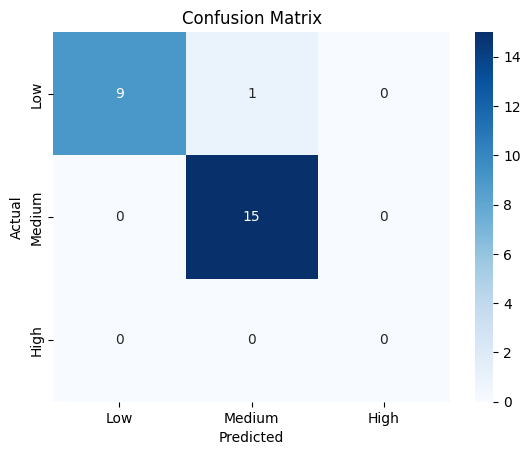


Baseline Accuracy: 0.56

Top Features:
- word_count: 0.51
- sentence_count: 0.47
- flesch_reading_ease: 0.02


/tmp/ipython-input-3471745504.py:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette="coolwarm")


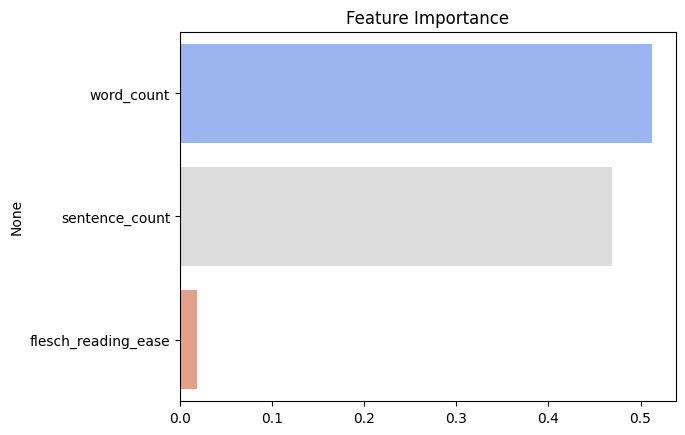


✅ Results saved to content_quality_predictions.csv


In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# =========================================================
# CONFIGURATION
# =========================================================
input_file = "extracted_features.csv"
target_column = "quality_label"

# =========================================================
# STEP 1: Load data
# =========================================================
df = pd.read_csv(input_file)

# If Flesch score missing, simulate based on sentence-to-word ratio
if "flesch_reading_ease" not in df.columns:
    print("ℹ️ Estimating Flesch Reading Ease using proxy formula...")
    # approximate readability = 206.835 - 1.015*(avg sentence length) - 84.6*(avg word length)
    # since we lack word length info, we’ll use sentence_count & word_count ratio
    df["avg_sentence_length"] = df["word_count"] / (df["sentence_count"] + 1)
    df["flesch_reading_ease"] = 206.835 - 1.015 * df["avg_sentence_length"]
    df["flesch_reading_ease"] = df["flesch_reading_ease"].clip(lower=0, upper=100)

# Check for required columns
required_cols = ["url", "word_count", "sentence_count", "flesch_reading_ease"]
for col in required_cols:
    if col not in df.columns:
        raise ValueError(f"❌ Missing required column: {col}")

# =========================================================
# STEP 2: Create synthetic quality labels
# =========================================================
def assign_quality(row):
    wc = row["word_count"]
    fr = row["flesch_reading_ease"]

    if wc > 1500 and 50 <= fr <= 70:
        return "High"
    elif wc < 500 or fr < 30:
        return "Low"
    else:
        return "Medium"

df[target_column] = df.apply(assign_quality, axis=1)

# =========================================================
# STEP 3: Train/Test Split
# =========================================================
X = df[["word_count", "sentence_count", "flesch_reading_ease"]]
y = df[target_column]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# =========================================================
# STEP 4: Model Training
# =========================================================
model = RandomForestClassifier(random_state=42, n_estimators=100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# =========================================================
# STEP 5: Evaluation
# =========================================================
print("\n=== Model Performance ===")
print(classification_report(y_test, y_pred))
print(f"Overall Accuracy: {accuracy_score(y_test, y_pred):.2f}")

cm = confusion_matrix(y_test, y_pred, labels=["Low", "Medium", "High"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Low", "Medium", "High"],
            yticklabels=["Low", "Medium", "High"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# =========================================================
# STEP 6: Baseline (Rule-based)
# =========================================================
def baseline_classifier(wc):
    if wc > 1500:
        return "High"
    elif wc < 500:
        return "Low"
    else:
        return "Medium"

baseline_pred = X_test["word_count"].apply(baseline_classifier)
baseline_acc = accuracy_score(y_test, baseline_pred)
print(f"\nBaseline Accuracy: {baseline_acc:.2f}")

# =========================================================
# STEP 7: Feature Importance
# =========================================================
importances = pd.Series(model.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False)

print("\nTop Features:")
for feature, imp in top_features.items():
    print(f"- {feature}: {imp:.2f}")

sns.barplot(x=importances.values, y=importances.index, palette="coolwarm")
plt.title("Feature Importance")
plt.show()

# =========================================================
# STEP 8: Save results
# =========================================================
results = pd.DataFrame({
    "url": df.loc[y_test.index, "url"],
    "actual_label": y_test,
    "predicted_label": y_pred
})
results.to_csv("content_quality_predictions.csv", index=False)
print("\n✅ Results saved to content_quality_predictions.csv")


In [17]:
data=pd.read_csv("content_quality_predictions.csv")
print(data)

                                                  url actual_label  \
0   https://martie.com/?srsltid=AfmBOoqTEC0QXQ3xYE...          Low   
1                https://comfax.com/reviews/free-fax/       Medium   
2   https://www.shopify.com/blog/ecommerce-seo-beg...       Medium   
3                 https://americasstealsanddeals.com/       Medium   
4   https://jakevdp.github.io/PythonDataScienceHan...          Low   
5        https://www.bbc.com/news/topics/c404v061z99t          Low   
6   https://mailchimp.com/marketing-glossary/conte...       Medium   
7   https://support.microsoft.com/en-us/windows/ho...       Medium   
8   https://en.wikipedia.org/wiki/Remote_desktop_s...          Low   
9   https://support.apple.com/guide/remote-desktop...       Medium   
10  https://www.cisecurity.org/insights/blog/11-cy...       Medium   
11  https://www.geeksforgeeks.org/data-science/dat...       Medium   
12  https://www.akkio.com/beginners-guide-to-machi...       Medium   
13  https://www.fort

5. Real-Time Analysis Demo

In [21]:
import requests
from bs4 import BeautifulSoup
import re
import numpy as np
import pandas as pd
import json
import torch
from sentence_transformers import SentenceTransformer, util

# Load existing dataset
existing_df = pd.read_csv("extracted_features.csv")

# Convert embeddings safely to float32 arrays
def parse_embedding(x):
    try:
        arr = np.array(json.loads(x), dtype=np.float32)
        return arr if arr.size > 0 else np.zeros(384, dtype=np.float32)
    except:
        return np.zeros(384, dtype=np.float32)

existing_df["embedding"] = existing_df["embedding"].apply(parse_embedding)

# Load transformer model
model = SentenceTransformer("all-MiniLM-L6-v2")

def clean_text(text):
    text = re.sub(r"\s+", " ", text)
    return text.strip().lower()

def flesch_reading_ease(words, sentences):
    if sentences == 0:
        return 0
    avg_sentence_length = words / sentences
    # simplified Flesch approximation
    return round(206.835 - 1.015 * avg_sentence_length, 2)

def classify_quality(word_count, readability):
    if word_count > 1500 and 50 <= readability <= 70:
        return "High"
    elif word_count < 500 or readability < 30:
        return "Low"
    else:
        return "Medium"

def analyze_url(url, similarity_threshold=0.75):
    try:
        # Step 1: Scrape page
        response = requests.get(url, timeout=10)
        soup = BeautifulSoup(response.text, "html.parser")

        # Step 2: Extract text
        title = soup.title.string if soup.title else ""
        paragraphs = [p.get_text() for p in soup.find_all("p")]
        text = clean_text(" ".join(paragraphs))
        if not text:
            return {"error": "No readable content found"}

        # Step 3: Extract features
        words = len(text.split())
        sentences = len(re.findall(r"[.!?]", text))
        readability = flesch_reading_ease(words, sentences)
        quality_label = classify_quality(words, readability)
        is_thin = words < 500

        # Step 4: Compute embedding (float32)
        new_embedding = model.encode(text, convert_to_tensor=True).to("cpu").to(torch.float32)

        # Step 5: Compute similarities
        similarities = []
        for _, row in existing_df.iterrows():
            existing_emb = torch.tensor(row["embedding"], dtype=torch.float32)
            sim = float(util.cos_sim(new_embedding, existing_emb))
            if sim > similarity_threshold:
                similarities.append({"url": row["url"], "similarity": round(sim, 2)})

        # Step 6: Return structured result
        result = {
            "url": url,
            "title": title,
            "word_count": words,
            "readability": readability,
            "quality_label": quality_label,
            "is_thin": is_thin,
            "similar_to": similarities
        }
        return result

    except Exception as e:
        return {"url": url, "error": str(e)}


In [22]:
result = analyze_url("https://www.varonis.com/blog/cybersecurity-tips")
print(json.dumps(result, indent=2))

{
  "url": "https://www.varonis.com/blog/cybersecurity-tips",
  "title": "Top 10 Cybersecurity Awareness Tips: How to Stay Safe and Proactive",
  "word_count": 2005,
  "readability": 188.98,
  "quality_label": "Medium",
  "is_thin": false,
  "similar_to": [
    {
      "url": "https://www.varonis.com/blog/cybersecurity-tips",
      "similarity": 0.94
    }
  ]
}


In [23]:
result = analyze_url("https://www.geeksforgeeks.org/machine-learning/supervised-machine-learning/")
print(json.dumps(result, indent=2))

{
  "url": "https://www.geeksforgeeks.org/machine-learning/supervised-machine-learning/",
  "title": "Supervised Machine Learning - GeeksforGeeks",
  "word_count": 1080,
  "readability": 173.62,
  "quality_label": "Medium",
  "is_thin": false,
  "similar_to": []
}
